# Overall
This note book shows the procedure to produce the scalability performance plot from DALiuGE

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)

## Schema of the dataset
    0.  user name (e.g. cwu)
    1.  facility (e.g. galaxy)
    2.  pipeline (e.g. lofar_std)
    3.  time (e.g. 2016-08-22T11-52-11/)
    4.  # of nodes
    5.  # of drops
    6.  Git commit number
    7.  unroll_time
    8.  translation_time
    9.  pg_spec_gen_time
    10. created_session_at_all_nodes_time
    11. graph_separation_time
    12. push_sub_graphs_to_all_nodes_time
    13. created_drops_at_all_nodes_time
    14. Num_pyro_connections_at_all_nodes
    15. created_pyro_conn_at_all_nodes_time
    16. triggered_drops_at_all_nodes_time
    17. Total completion time

## Load the dataset

In [2]:
csv_file = 'presult.csv'
df = pd.read_csv(csv_file, header=None)

num_tests, num_attr = df.shape
print("In total {0} tests run and {1} attributes recorded".format(num_tests, num_attr))
# just show the first three examples
df

In total 26 tests run and 18 attributes recorded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,cwu,magnus,lofar_test_4x4,2016-08-24T10-49-18,9,348,None,0.005,0.285,0.001,0.010,0.002,0.342,0.094,154,0.450999975204,0.0390000343323,-1.000
1,cwu,magnus,lofar_test_32x32,2016-08-25T22-24-39,30,17078,b0142623e6b180de8302273efdc18cb046f389ef,0.350,1.140,0.012,0.018,0.153,0.795,0.382,9186,14.8949999809,2.6400001049,122.511
2,cwu,magnus,lofar_test_128x128,2016-08-25T22-25-00,30,264902,b0142623e6b180de8302273efdc18cb046f389ef,34.399,18.003,0.195,0.019,4.362,2.392,18.319,-1,None,None,-1.000
3,cwu,magnus,lofar_test_64x64,2016-08-25T22-24-46,30,66918,b0142623e6b180de8302273efdc18cb046f389ef,3.329,4.356,0.048,0.018,0.837,1.087,2.011,33446,160.111000061,10.1809999943,571.064
4,cwu,magnus,lofar_test_8x16,2016-08-25T19-08-37,50,2226,None,0.032,0.337,0.001,0.029,0.019,1.012,0.074,1466,1.26900005341,0.380999803543,41.476
5,cwu,magnus,lofar_test_16x32,2016-08-25T22-24-36,30,8886,b0142623e6b180de8302273efdc18cb046f389ef,0.145,0.684,0.006,0.019,0.069,0.972,0.194,4524,3.68699979782,1.41300010681,193.434
6,cwu,magnus,lofar_std,2016-08-22T11-52-11,4,192,None,0.003,0.295,0.001,0.005,0.001,0.389,0.123,38,0.34700012207,0.0190000534058,-1.000
7,cwu,magnus,lofar_test_4x4,2016-08-24T10-49-04,4,348,None,0.005,0.260,0.001,0.005,0.002,0.294,0.156,152,0.426000118256,0.171000003815,-1.000
8,cwu,magnus,lofar_test_32x64,2016-08-25T22-24-42,30,34150,b0142623e6b180de8302273efdc18cb046f389ef,1.031,2.274,0.025,0.018,0.309,0.886,0.954,16778,28.2779998779,5.625,433.125
9,cwu,magnus,lofar_test_2x4,2016-08-24T10-34-22,14,220,None,0.003,0.253,0.000,0.016,0.001,0.317,0.064,126,0.417999982834,0.0220000743866,-1.000


Show tests that have successfully completed its execution on 30 nodes (sort based on # of drops and # of relationships)

In [3]:
runs_30 = df[(df[4] == 30) & (df[16] != 'None')].sort_values(by=[5, 14])
runs_30

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
12,cwu,magnus,lofar_test_16x16,2016-08-25T22-24-30,30,4446,b0142623e6b180de8302273efdc18cb046f389ef,0.065,0.446,0.003,0.018,0.032,0.903,0.113,2462,2.39399981499,0.672000169754,42.722
5,cwu,magnus,lofar_test_16x32,2016-08-25T22-24-36,30,8886,b0142623e6b180de8302273efdc18cb046f389ef,0.145,0.684,0.006,0.019,0.069,0.972,0.194,4524,3.68699979782,1.41300010681,193.434
1,cwu,magnus,lofar_test_32x32,2016-08-25T22-24-39,30,17078,b0142623e6b180de8302273efdc18cb046f389ef,0.350,1.140,0.012,0.018,0.153,0.795,0.382,9186,14.8949999809,2.6400001049,122.511
8,cwu,magnus,lofar_test_32x64,2016-08-25T22-24-42,30,34150,b0142623e6b180de8302273efdc18cb046f389ef,1.031,2.274,0.025,0.018,0.309,0.886,0.954,16778,28.2779998779,5.625,433.125
3,cwu,magnus,lofar_test_64x64,2016-08-25T22-24-46,30,66918,b0142623e6b180de8302273efdc18cb046f389ef,3.329,4.356,0.048,0.018,0.837,1.087,2.011,33446,160.111000061,10.1809999943,571.064
15,cwu,magnus,lofar_test_64x128,2016-08-25T22-24-51,30,133830,b0142623e6b180de8302273efdc18cb046f389ef,10.367,9.024,0.097,0.019,1.885,2.133,5.831,66584,622.955000162,20.7730000019,1034.751


## Plot 1
The first set of graphs show the time spend on varoius metrics when we increase the number of Drops or Drop relationships given a fixed set of nodes (e.g. 30 or 60).

So first define a function

In [4]:
def plot_time_vs_drops(num_nodes, x_axis='num_drops'):
    runs_data = df[(df[4] == num_nodes) & (df[16] != 'None')].sort_values(by=[5, 14])
    if (x_axis == 'num_rel'):
        x = runs_data.ix[:, 14].values
        x_label = '# of Relationships'
    else:
        x = runs_data.ix[:, 5].values
        x_label = '# of Drops'
    y1 = runs_data.ix[:, 7:13].values 
    y2 = runs_data.ix[:, 15:17].values.astype(float)
    y3 = y2.T[2] - y2.T[1] - y2.T[0] # get the execution time
    y4 = np.vstack([y2.T, y3.T]).T

    labels_1 = ['unroll', 'translate', 'pg_spec', 'session', 'separation', 'push_graph', 'created_drop']
    marker_1 = ['o', 'v', '^', '8', 's', 'x', 'D']
    labels_2 = ['relation', 'trigger', 'completion', 'execution']
    marker_2 = marker_1[0:5]
    f = plt.figure(1)
    f.suptitle("Time spent when increasing the {1} running on {0} nodes".format(num_nodes, x_label), fontsize=17)
    plt.subplot(121)
    for i in range(len(labels_1)):
        lines = plt.plot(x, y1[:,i], linewidth=2, label=labels_1[i], 
                 marker=marker_1[i], markersize=9, markerfacecolor='none', markeredgewidth=2)
        lines[0].set_markeredgecolor(lines[0].get_color())
    plt.legend(loc='upper left')
    plt.ylabel('Seconds', fontsize=15)
    plt.xlabel(x_label, fontsize=15)
    plt.title('Preparation related time', fontsize=15)
    plt.subplot(122)
    for i in range(len(labels_2)):
        lines = plt.plot(x, y4[:,i], linewidth=2, label=labels_2[i], 
                 marker=marker_2[i], markersize=9, markerfacecolor='none', markeredgewidth=2)
        lines[0].set_markeredgecolor(lines[0].get_color())
    plt.legend(loc='upper left')
    plt.ylabel('Seconds', fontsize=15)
    plt.xlabel(x_label, fontsize=15)
    plt.title('Execution related time', fontsize=15)


First, try 30 nodes

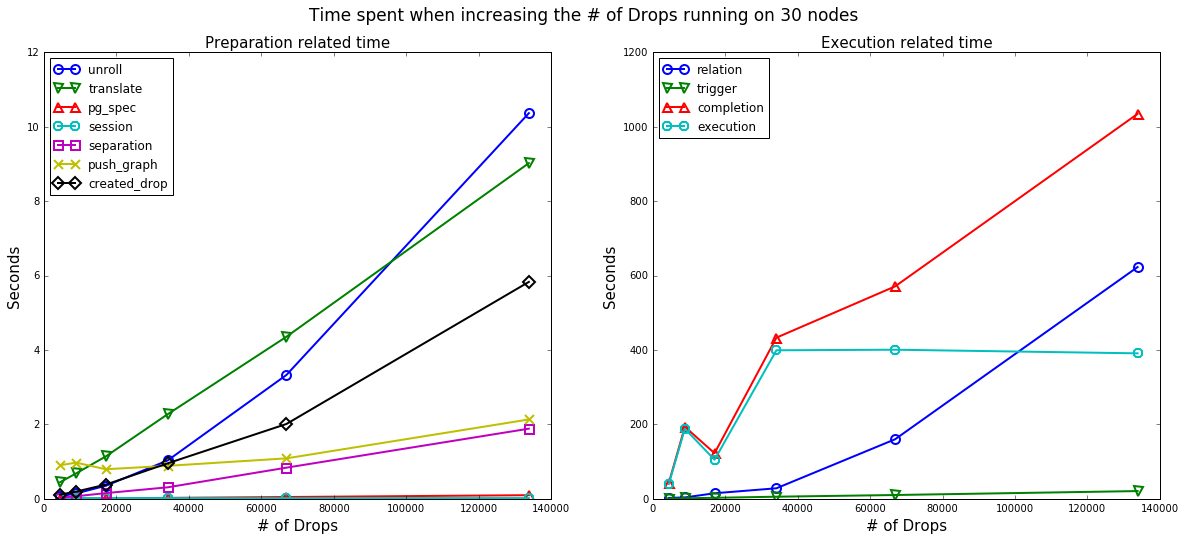

In [5]:
plot_time_vs_drops(30)

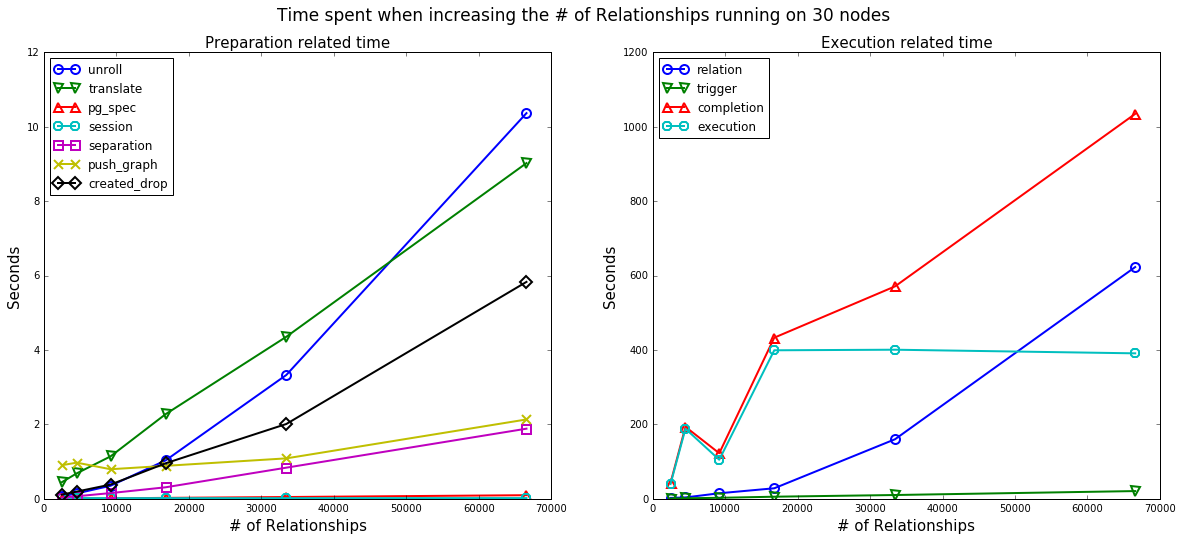

In [6]:
plot_time_vs_drops(30, x_axis='num_rel')

Now try 60 nodes...

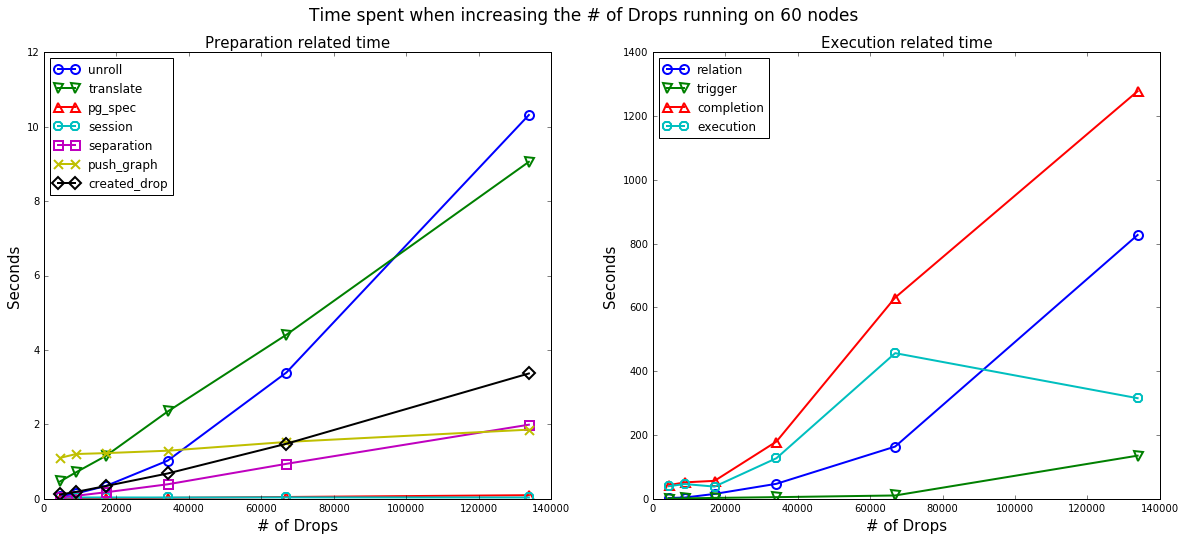

In [7]:
plot_time_vs_drops(60)

Then try increasing the number of relationships (instead of # of Drops) running on 60 nodes

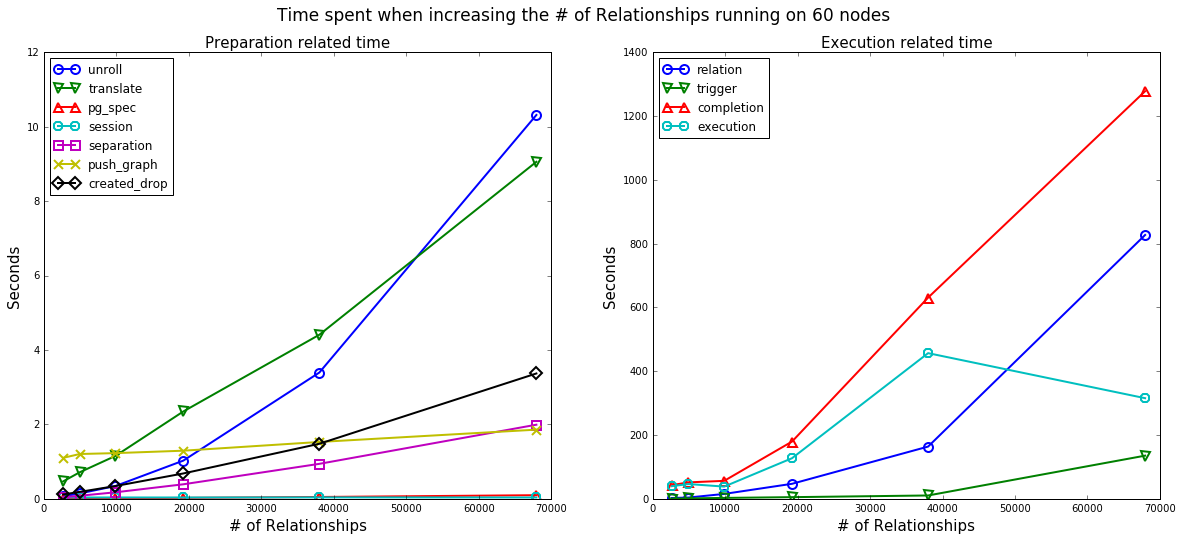

In [8]:
plot_time_vs_drops(60, x_axis='num_rel')

## Plot 2
The association between # of Drops and # of Relationships under different # of Nodes

In [9]:
def plot_rel_vs_drops(num_nodes=[]):
    markers = itertools.cycle((',', '+', '.', 'o', '*'))
    for nn in num_nodes:
        run = df[(df[4] == nn) & (df[14] != -1)].sort_values(by=[5, 14])
        x = run.ix[:, 5].values
        y = run.ix[:, 14].values
        ls = plt.plot(x, y, label='{0} nodes'.format(nn), marker=markers.next(), 
                 markersize=10, markeredgewidth=2, markerfacecolor='none', linewidth=2)
        ls[0].set_markeredgecolor(ls[0].get_color())
    plt.ylabel('# of Relationships', fontsize=15)
    plt.xlabel('# of Drops', fontsize=15)
    plt.legend(loc='upper left', fontsize=15)

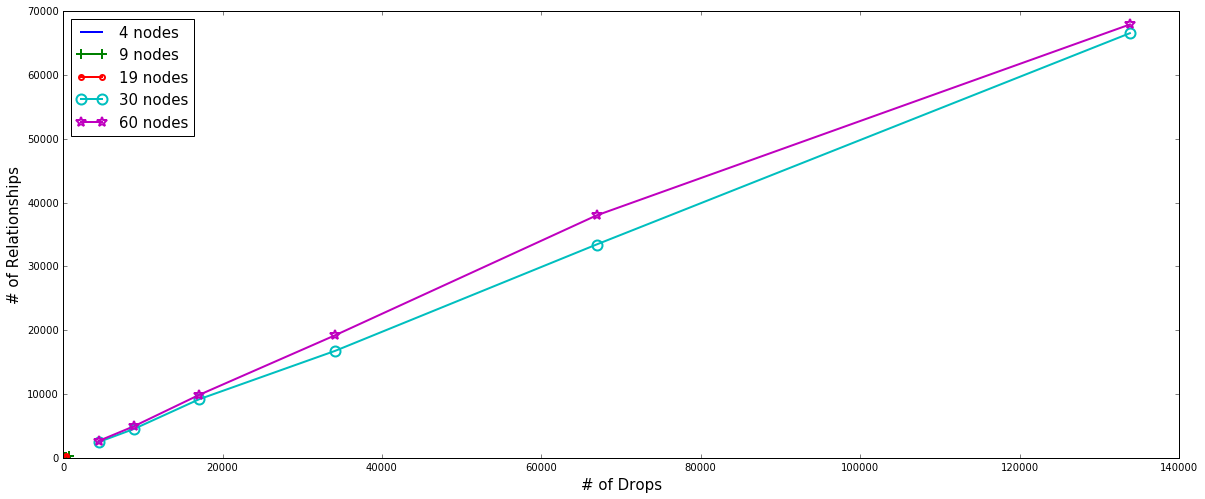

In [10]:
plot_rel_vs_drops(num_nodes=[4,9,19,30,60])

## Plot 3
the time spend on varoius metrics when we increase the # of nodes given a fixed set of Drops. Since the level of # of nodes is not so many, it is best to use a bar chart to illustrate this.

In [11]:
gby_nodes = df[(df[14] != -1) & (df[17] != -1)].groupby(4) # group by # of nodes
gby_nodes.groups

{25: [25], 30: [1, 3, 5, 8, 12, 15], 50: [4], 60: [10, 11, 14, 16, 17, 18]}

In [12]:
df30 = df.iloc[gby_nodes.groups[30]][[5, 17]]

In [13]:
df60 = df.iloc[gby_nodes.groups[60]][[5, 17]]

In [14]:
df30_1 = pd.DataFrame({'17_30': list(df30[[17]].values.flatten())}, index=list(df30[[5]].values[:,0]))
df30_1

,17_30
17078,122.511
66918,571.064
8886,193.434
34150,433.125
4446,42.722
133830,1034.751


In [15]:
df60_1 = pd.DataFrame({'17_60': list(df60[[17]].values.flatten())}, index=list(df60[[5]].values[:,0]))
df60_1

,17_60
34150,179.442
17078,56.337
66918,631.014
8886,51.523
4446,42.813
133830,1278.252


In [16]:
both_df = df30_1.join(df60_1).sort_index()

In [17]:
both_df

,17_30,17_60
4446,42.722,42.813
8886,193.434,51.523
17078,122.511,56.337
34150,433.125,179.442
66918,571.064,631.014
133830,1034.751,1278.252


In [18]:
nodes_30 = both_df[['17_30']].values.flatten()

In [19]:
nodes_60 = both_df[['17_60']].values.flatten()

In [20]:
x_tick_labels = [str(x) + ' Drops' for x in sorted(df30_1.index.values)]
x_tick_labels

['4446 Drops',
 '8886 Drops',
 '17078 Drops',
 '34150 Drops',
 '66918 Drops',
 '133830 Drops']

In [21]:
N = len(nodes_30)

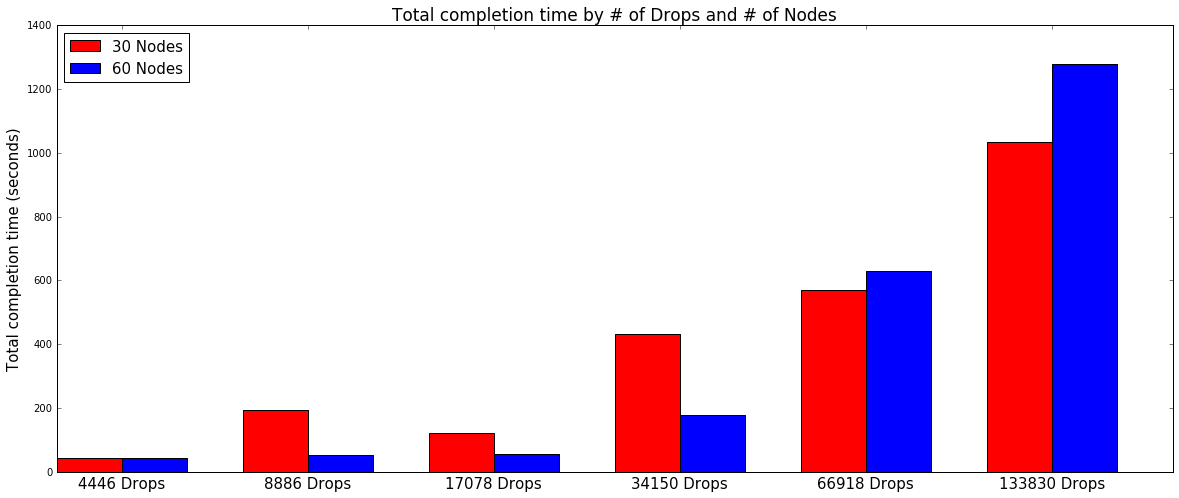

In [22]:
width = 0.35
ind = np.arange(N)
b1 = plt.bar(ind, nodes_30, width, color='r')
b2 = plt.bar(ind + width, nodes_60, width, color='b')
plt.xticks(ind + width, x_tick_labels, fontsize=15)
plt.ylabel('Total completion time (seconds)', fontsize=15)
plt.title('Total completion time by # of Drops and # of Nodes', fontsize=17)
plt.legend((b1, b2), ('30 Nodes', '60 Nodes'), loc='upper left', fontsize=15)